# ABoffsets_LSSTComCam_c26202


Created:  2024.11.15

## 1. Initial Setup...

### 1.1 Import useful python packages

In [2]:
# Generic python packages
import pylab as plt
import numpy as np
import pandas as pd
import glob
import math
import os
import gc

# LSST Science Pipelines (Stack) packages
import lsst.daf.butler as dafButler
import lsst.afw.display as afwDisplay

# Set a standard figure size to use
plt.rcParams['figure.figsize'] = (8.0, 8.0)
afwDisplay.setDefaultBackend('matplotlib')

In [3]:
from astropy.wcs import WCS
from astropy.visualization import LinearStretch, ImageNormalize
from PIL import Image
import warnings
#add warning suppress
warnings.simplefilter("ignore", category=UserWarning)

from astropy.stats import sigma_clipped_stats

import lsst.geom as geom
from lsst.pipe.tasks.registerImage import RegisterConfig, RegisterTask

In [4]:
def cutout_im(butler, ra, dec, datasetType, visit, detector, cutoutSideLength=51, **kwargs):
    
    """
    Produce a cutout from a calexp at the given ra, dec position.

    Adapted from cutout_coadd which was adapted from a DC2 tutorial
    notebook by Michael Wood-Vasey.

    """
    
    dataId = {'visit': visit, 'detector': detector}    
    radec = geom.SpherePoint(ra, dec, geom.degrees)
    cutoutSize = geom.ExtentI(cutoutSideLength, cutoutSideLength)
    wcs = butler.get('%s.wcs' % datasetType,**dataId)
    xy = geom.PointI(wcs.skyToPixel(radec))
    bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)
    parameters = {'bbox': bbox}
    cutout_image = butler.get(datasetType, parameters=parameters, **dataId)

    return cutout_image

In [5]:
def warp_img(ref_img, img_to_warp, ref_wcs, wcs_to_warp):

    config = RegisterConfig()
    task = RegisterTask(name="register", config=config)
    warpedExp = task.warpExposure(img_to_warp, wcs_to_warp, ref_wcs,
                                  ref_img.getBBox())

    return warpedExp

In [6]:
def make_gif(frame_folder):
    frames = [Image.open(image) for image in sorted(glob.glob(f"{frame_folder}/*.png"))]
    frame_one = frames[0]
    frame_one.save("animation.gif", format="GIF", append_images=frames,
               save_all=True, duration=500, loop = 0)

### 1.2 Set some standard variables

**Tina:  We might need to update the values for `repo` and `collections` when we find out the official values for these on Monday or so.  That said, the current values seem to be giving results...**

**UPDATE (18 Nov 2024):  These are the correct alues for `repo` and `collections`!  Yay!**

In [7]:
# See https://rubinobs.atlassian.net/wiki/spaces/DM/pages/48834013/Campaigns#1.1.-ComCam
# and https://rubinobs.atlassian.net/wiki/spaces/DM/pages/226656354/LSSTComCam+Intermittent+Cumulative+DRP+Runs
repo = '/repo/dp1'
#collections = 'LSSTComCam/runs/DRP/20241101_20241113/w_2024_46/DM-47566'
#collections = 'LSSTComCam/runs/DRP/20241101_20241127/w_2024_48/DM-47841'
#collections = 'LSSTComCam/runs/DRP/20241101_20241204/w_2024_49/DM-47988'
collections = 'LSSTComCam/runs/DRP/DP1/v29_0_0/DM-50260'

instrument = 'LSSTComCam'
skymap_name = 'lsst_cells_v1'


### 1.3 Define some useful python methods/classes for use later in the notebook

In [8]:
# Useful class to stop "Run All" at a cell 
#  containing the command "raise StopExecution"
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

## 2. LSST Synthetic AB magnitudes for C26202, based on official filter LSST (v1.9) bandpasses

**Tina:  Could you update these values based on the ugrizy values for basename=c26202_mod_007 in:**

**`/home/d/dltucker/DATA/SynthMags/synthMagColorList.lsst_v1.9.calspec_20240603.added_info.csv` ?**  

**Currently, the values below are from the Dark Energy Survey (DES) ugrizy filter passbands.**

**Thanks!**



In [9]:
# c26202_mod_007 (v2024_06_03 release of STScI/HST CalSpec standards). Updated 11/18/24 from CSV file above
u_hst24 = 17.5909
g_hst24 = 16.6944
r_hst24 = 16.3634
i_hst24 = 16.2619
z_hst24 = 16.2469
y_hst24 = 16.2424


## 3. Query USDF Butler for ComCam measurements of C26202

### 3.1 Instantiate Butler

In [10]:
butler = dafButler.Butler(repo, collections=collections)

### 3.2 Find all the `calexp`'s that overlap the sky position of C26202

RA, DEC of C26202 in degrees (from `/home/d/dltucker/DATA/SynthMags/synthMagColorList.lsst_v1.9.calspec_20240603.added_info.csv`):

In [11]:
raDeg = 53.136845833333325
decDeg = -27.86349444444444

Find the `dataId`'s for all `calexp`'s in this repo/collection that overlap the RA, DEC of C26202:

In [12]:
datasetRefs = butler.query_datasets("preliminary_visit_image", where="visit_detector_region.region OVERLAPS POINT(ra, dec)",
                                    bind={"ra": raDeg, "dec": decDeg})

for i, ref in enumerate(datasetRefs):    
    print(i, ref.dataId)

print(f"\nFound {len(datasetRefs)} calexps")

0 {instrument: 'LSSTComCam', detector: 5, visit: 2024120500122, band: 'r', day_obs: 20241205, physical_filter: 'r_03'}
1 {instrument: 'LSSTComCam', detector: 5, visit: 2024120900310, band: 'r', day_obs: 20241209, physical_filter: 'r_03'}
2 {instrument: 'LSSTComCam', detector: 4, visit: 2024110800288, band: 'r', day_obs: 20241108, physical_filter: 'r_03'}
3 {instrument: 'LSSTComCam', detector: 5, visit: 2024110800251, band: 'r', day_obs: 20241108, physical_filter: 'r_03'}
4 {instrument: 'LSSTComCam', detector: 3, visit: 2024111900094, band: 'y', day_obs: 20241119, physical_filter: 'y_04'}
5 {instrument: 'LSSTComCam', detector: 0, visit: 2024111700154, band: 'r', day_obs: 20241117, physical_filter: 'r_03'}
6 {instrument: 'LSSTComCam', detector: 5, visit: 2024120900311, band: 'r', day_obs: 20241209, physical_filter: 'r_03'}
7 {instrument: 'LSSTComCam', detector: 3, visit: 2024120600097, band: 'r', day_obs: 20241206, physical_filter: 'r_03'}
8 {instrument: 'LSSTComCam', detector: 3, visit:

**Tina, could use add some code here from the DP02_04b_Intermediate_Butler_Queries tutorial notebook so we can view these `calexp` images?  Maybe something from Section 3.1 from that tutorial notebook.  It would be good to take a look at the individual images in case there are any weird `calexp` images that we should ignore.**

This is from DP02_4b - getting catalog data

In [13]:
calexp = butler.get('preliminary_visit_image', dataId={'visit': 2024112000209, 'detector': 8})

In [14]:
calexp_info = calexp.getInfo()

In [15]:
visit_info = calexp_info.getVisitInfo()
summary_info = calexp_info.getSummaryStats()

In [28]:
visit_info

VisitInfo(exposureTime=30, darkTime=30.4338, date=2024-11-21T05:51:33.159502334, UT1=nan, ERA=2.58559 rad, boresightRaDec=(52.9348959817, -28.1643908856), boresightAzAlt=(269.7123524231, +68.6153019154), boresightAirmass=1.07379, boresightRotAngle=1.76956 rad, rotType=1, observatory=-30.2446N, -70.7494E  2663, weather=Weather(10.625, 74315, 28.575), instrumentLabel='LSSTComCam', id=2024112000209, focusZ=2.18942, observationType='science', scienceProgram='BLOCK-320', observationReason='science', object='ECDFS', hasSimulatedContent=false)

In [16]:
summary_info

ExposureSummaryStats(version=0, psfSigma=2.417947967511231, psfArea=96.4005256991185, psfIxx=6.005837073183664, psfIyy=5.706254399289783, psfIxy=-0.29932424743255953, ra=53.232549861808636, dec=-27.96108452313704, pixelScale=0.20041118751530185, zenithDistance=21.3903733552238, expTime=30.0, zeroPoint=32.04384157380644, skyBg=1637.8494873046875, skyNoise=43.45327858204136, meanVar=1895.1782913296029, raCorners=[53.08376121679534, 53.13412224749524, 53.3812333272909, 53.33126808699482], decCorners=[-28.05043701745667, -27.82818510223779, -27.87148762740684, -28.093884799154498], astromOffsetMean=0.009836269925020716, astromOffsetStd=0.0051735696488176865, nPsfStar=99, psfStarDeltaE1Median=0.0008205072954297456, psfStarDeltaE2Median=0.0012398939579725786, psfStarDeltaE1Scatter=0.011004910193503201, psfStarDeltaE2Scatter=0.012541718661807255, psfStarDeltaSizeMedian=0.0008466519958711949, psfStarDeltaSizeScatter=0.0158635832088403, psfStarScaledDeltaSizeScatter=0.006577719664663458, psfTra

In [32]:
calexp_info.getFilter()

FilterLabel(band="r", physical="r_03")

From dp02_4a, section 3.1

In [17]:
datasetType = 'preliminary_visit_image'
dataId = {'visit': 2024112000209, 'detector': 8}
calexp = butler.get(datasetType, dataId=dataId)

In [18]:
print(butler.registry.getDatasetType(datasetType))

DatasetType('preliminary_visit_image', {band, instrument, day_obs, detector, physical_filter, visit}, ExposureF)


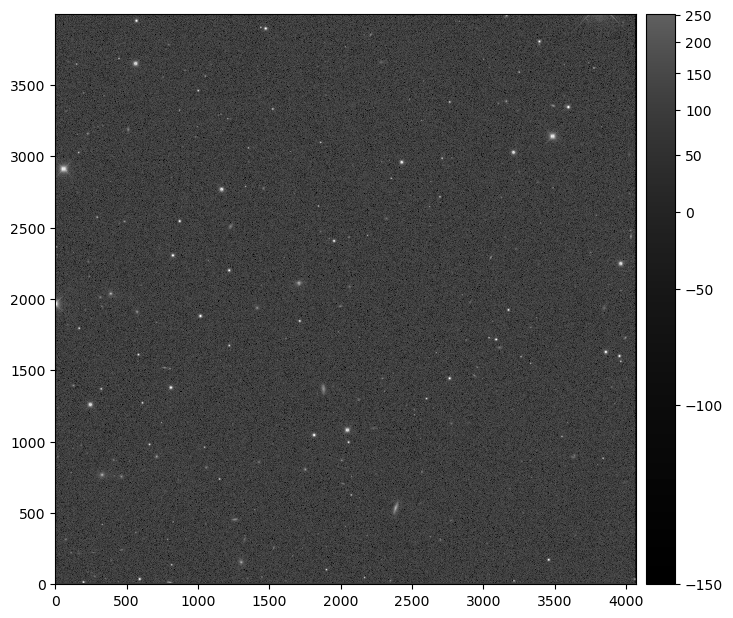

In [19]:
fig = plt.figure()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(calexp.image)
plt.show()

In [20]:
cutoutsize = 501 #Defining the size of the cutout box in pixels
visit = 2024110800251
detector = 5

In [21]:
cutout_calexp = cutout_im(butler, raDeg, decDeg, 'preliminary_visit_image', visit, detector, cutoutSideLength=cutoutsize)

In [35]:
visit

2024110800251

In [36]:
detector

5

In [37]:
calexp_info.getFilter()

FilterLabel(band="r", physical="r_03")

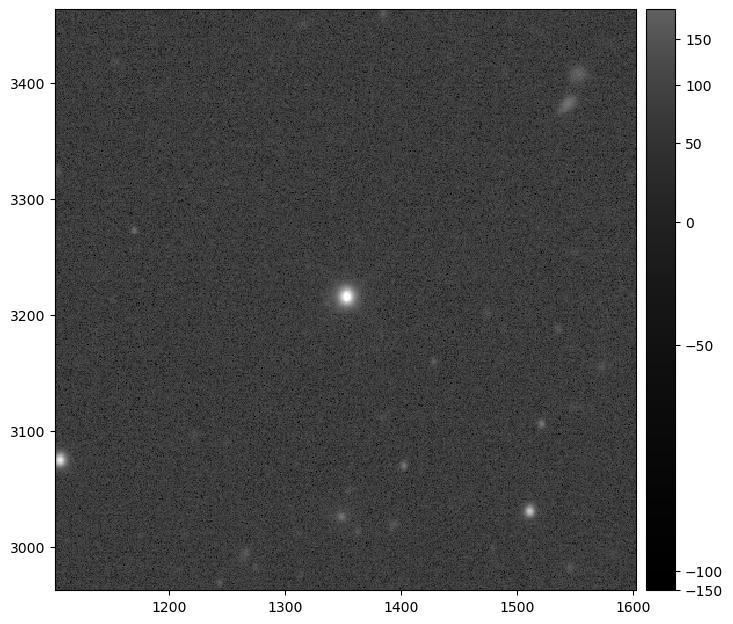

In [22]:
fig = plt.figure()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(cutout_calexp.image)
plt.show()

Now, loop over the `datasetRefs` again, but this time grab the contents of the `sourceTable` for each `ref` and combine it all into one big pandas DataFrame:

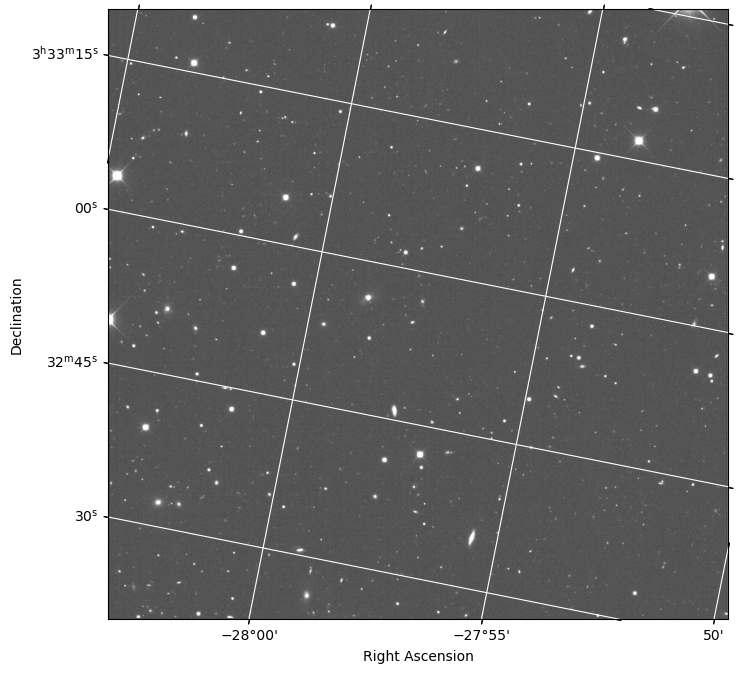

In [23]:
fig = plt.figure()
plt.subplot(projection=WCS(calexp.getWcs().getFitsMetadata()))
calexp_extent = (calexp.getBBox().beginX, calexp.getBBox().endX,
                 calexp.getBBox().beginY, calexp.getBBox().endY)
im = plt.imshow(calexp.image.array, cmap='gray', vmin=-200.0, vmax=400,
                extent=calexp_extent, origin='lower')
plt.grid(color='white', ls='solid')
plt.xlabel('Right Ascension')
plt.ylabel('Declination')
plt.show()

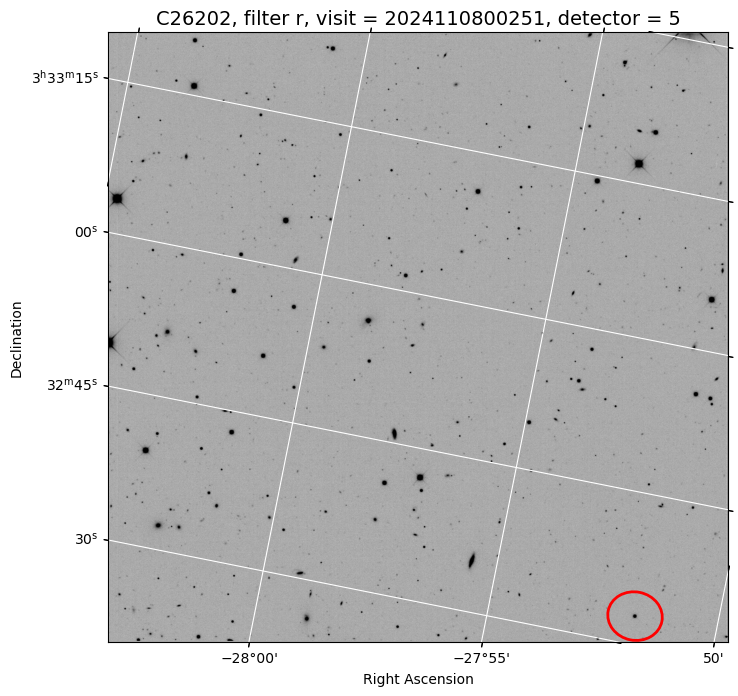

In [34]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from astropy.wcs import WCS

# Your existing setup
fig = plt.figure()
ax = plt.subplot(projection=WCS(calexp.getWcs().getFitsMetadata()))
calexp_extent = (calexp.getBBox().beginX, calexp.getBBox().endX,
                 calexp.getBBox().beginY, calexp.getBBox().endY)
im = ax.imshow(calexp.image.array, cmap='gray_r', vmin=-200.0, vmax=400,
               extent=calexp_extent, origin='lower')
ax.grid(color='white', ls='solid')
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')


# Add a title
ax.set_title('C26202, filter r, visit = 2024110800251, detector = 5', fontsize=14, color='black')


# Coordinates of the star in degrees
raDeg = 53.136845833333325
decDeg = -27.86349444444444

# Add a circle around the star (in sky coordinates)
circle = patches.Circle((raDeg, decDeg), radius=0.01,  # adjust radius as needed
                        transform=ax.get_transform('world'),
                        edgecolor='red', facecolor='none', linewidth=2)
ax.add_patch(circle)

plt.show()


In [22]:
src_list = []

for i, ref in enumerate(datasetRefs):
    
    # Retrieve sourceTable for this visit & detector...
    dataId = {'visit': ref.dataId['visit'], 'detector': ref.dataId['detector']}
    src = butler.get('sourceTable', dataId=dataId)
    src_list.append(src)
    print(f"{i} Visit {ref.dataId['visit']}, Detector {ref.dataId['detector']}:  Retrieved catalog of {len(src)} sources.")

src_all = pd.concat(src_list, ignore_index=True)

print("")
print(f"Total combined catalog contains {len(src_all)} sources.")


MissingDatasetTypeError: "Dataset type 'sourceTable' does not exist."

Let's look at the result:

In [ ]:
src_all

Let's save `src_all` as a CSV file that we can download and examine with TOPCAT:

In [ ]:
src_all.to_csv('LSSTComCam_C26202_fields2.csv', index=False)

**Tina, could you download and look at/plot the contents of `LSSTComCam_C26202_fields.csv` with TOPCAT?  Maybe sky positions, calibFlux, psfFlux, magCalib (= -2.5\*log10(calibFlux)+31.4), magPSF (= -2.5\*log10(calibFlux)+31.4) for the different filters, etc.?** 

**Remember, the sky position for the star C26202 is raDeg = 53.136845833333325, decDeg = -27.86349444444444; so maybe you can identify it (and create a TOPCAT subset for it) in TOPCAT.**

In [ ]:
_

**Let's stop here for now:**

In [ ]:
raise StopExecution

In [ ]:
# Observed DES DR2 magnitudes for C26202 (from Y6A2_COADD_OBJECTS_SUMMARY table)...
g_wavg,r_wavg,i_wavg,z_wavg,Y_wavg = 16.695784,16.342682,16.25813,16.240156,16.263472
g_auto,r_auto,i_auto,z_auto,Y_auto = 16.693335,16.341341,16.256319,16.238766,16.268082

## 4. Measure differences between the Observed ComCam and the LSST Synthetic Mags for C26202

In [ ]:
# DES DR2 AB offsets based on c26202_stisnic_007.fits from William Wester's DES-doc#15451...

print "AB offsets based on c26202_stisnic_007.fits"
print "==========================================="
print 

aboffset_i = i_wavg - i_ww
aboffset_gr = (g_wavg-r_wavg) - (g_ww-r_ww)
aboffset_ri = (r_wavg-i_wavg) - (r_ww-i_ww)
aboffset_iz = (i_wavg-z_wavg) - (i_ww-z_ww)
aboffset_zY = (z_wavg-Y_wavg) - (z_ww-Y_ww)

print "WAVG offsets"
print "------------"
print """i:    %10.4f""" % (aboffset_i)
print """g-r:  %10.4f""" % (aboffset_gr)
print """r-i:  %10.4f""" % (aboffset_ri)
print """i-z:  %10.4f""" % (aboffset_iz)
print """z-Y:  %10.4f""" % (aboffset_zY)
print 

aboffset_i = i_wavg - i_ww
aboffset_gr = (g_auto-r_auto) - (g_ww-r_ww)
aboffset_ri = (r_auto-i_auto) - (r_ww-i_ww)
aboffset_iz = (i_auto-z_auto) - (i_ww-z_ww)
aboffset_zY = (z_auto-Y_auto) - (z_ww-Y_ww)

print "MAG_AUTO offsets"
print "----------------"
print """i:    %10.4f""" % (aboffset_i)
print """g-r:  %10.4f""" % (aboffset_gr)
print """r-i:  %10.4f""" % (aboffset_ri)
print """i-z:  %10.4f""" % (aboffset_iz)
print """z-Y:  %10.4f""" % (aboffset_zY)
print 


## 5. Sandbox

In [ ]:
datasetRefs = butler.query_datasets("visitSummary", where="visit_detector_region.region OVERLAPS POINT(ra, dec)",
                                    bind={"ra": raDeg, "dec": decDeg})

#print(datasetRefs)

print(f"\nFound {len(datasetRefs)} calexps")

In [ ]:
# Retrieve sourceTable for this visit & detector...

datasetType = 'sourceTable'
#dataId = {'visit': visit, 'detector': detector}
dataId = ref.dataId['visit']
dataId = {'visit': ref.dataId['visit'], 'detector': ref.dataId['detector']}
print(dataId)

src = butler.get(datasetType, dataId=dataId)

print(f"Retrieved catalog of {len(src)} sources.")

In [ ]:
butler.registry.queryDataIds(dimensions=('exposure'))